In [1]:
import numpy as np
import networkx as nx
import kmapper as km
import sklearn
import warnings
import matplotlib.pyplot as plt
import signal
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
import math
import statistics
from networkx.algorithms.similarity import graph_edit_distance
warnings.filterwarnings("ignore")


In [2]:
def select_k(spectrum, minimum_energy = 0.9):
    running_total = 0.0 
    
    total = sum(spectrum)
    if total == 0.0:
        return len(spectrum)
    for i in range(len(spectrum)):
        running_total += spectrum[i]
        if running_total / total >= minimum_energy:
            return i + 1
    return len(spectrum)

In [3]:
def calculate_similarity(graph1,graph2):
    laplacian1 = nx.spectrum.laplacian_spectrum(graph1)
    laplacian2 = nx.spectrum.laplacian_spectrum(graph2)
    
    k1 = select_k(laplacian1)
    k2 = select_k(laplacian2)
    k = min(k1, k2) #k are different between the two graphs, then use the smaller one.
    similarity = sum((laplacian1[:k] - laplacian2[:k])**2) #sum of the squared differences between the largest k eigenvalues
    return similarity

In [4]:
def extract_graph_features(graph):
    pr = nx.pagerank(graph,0.9)
    dc = nx.degree_centrality(graph)
    cc = nx.closeness_centrality(graph)
    bx = nx.betweenness_centrality(graph)
    c = nx.clustering(graph)
    
    #create list for each features
    pr_list =  [i for i in pr.values()]
    dc_list =  [i for i in dc.values()]
    cc_list =  [i for i in cc.values()]
    bx_list =  [i for i in bx.values()]
    c_list =  [i for i in c.values()]
    d_list = [val for (node, val) in graph.degree()]
    data = np.column_stack((pr_list,dc_list,cc_list,bx_list,c_list,d_list))
    return data

In [10]:
def TDA_transformation(data):
    Xfilt = data
    mapper = km.KeplerMapper()
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
    Xfilt = scaler.fit_transform(Xfilt)
    lens = mapper.fit_transform(Xfilt, projection=sklearn.manifold.TSNE())
    cls = 5  # We use cls= 5

    #fail: 5 - 5 - 0.4
    graph = mapper.map(lens,Xfilt,clusterer=sklearn.cluster.KMeans(n_clusters=cls,random_state=1618033),
        cover=km.Cover(n_cubes=2, perc_overlap=0.5)) #0.3
    return km.to_nx(graph)

In [6]:
def calc_average_for_hop(hop,ref_graph,n,m,delta_n,delta_m):
    original = []
    TDA =[]
    
    for i in range(-hop,hop + 1):
        for j in range(-hop,hop + 1):
            if (i == -hop or i == hop or j == -hop or j == hop):
                neighbour = nx.barabasi_albert_graph(i*delta_n + n,j*delta_m + m)
                
                TDA_graph = TDA_transformation(extract_graph_features(ref_graph))
                TDA_neighbour = TDA_transformation(extract_graph_features(neighbour))
                
                score_TDA = calculate_similarity(TDA_graph, TDA_neighbour)
                score_original = calculate_similarity(ref_graph, neighbour)
                
                original.append(score_original)
                TDA.append(score_TDA)
    print(hop,statistics.median(TDA),statistics.median(original))
    return {"hop" : hop,"TDA": statistics.median(TDA),"original": statistics.median(original),"TDA-list" : TDA,"original-list":original}
                

In [7]:
def conduct_test_for_on_graph(graph,n,m,delta_n,delta_m,n_hop):
    result = [dict() for x in range(n_hop)]
    for i in range(n_hop):
        result[i] = calc_average_for_hop(hop =i+1,ref_graph = graph,n = n,m = m,delta_n = delta_n,delta_m = delta_m)
    return {"n" : n,"m" : m,"Result" : result}

In [12]:
G = nx.barabasi_albert_graph(500,20)

result = conduct_test_for_on_graph(G,500,20,20,1,4)
result

1 7.300917404737261 12485.455255458306
2 8.766436513260391 29083.923405946258
3 6.697606802992246 45976.36282904638
4 9.245007655786566 63713.559491039545


{'n': 500,
 'm': 20,
 'Result': [{'hop': 1,
   'TDA': 7.300917404737261,
   'original': 12485.455255458306,
   'TDA-list': [8.27757669649011,
    2.911929724316439,
    5.255551986346612,
    6.3242581129844115,
    5.178961100778389,
    35.373046136747995,
    19.193813830414264,
    10.949986746353408],
   'original-list': [5679.112010127311,
    12788.685492863986,
    21620.44508551238,
    3444.88091885731,
    2470.647708888143,
    30318.027216336624,
    14541.390431992688,
    12182.225018052624]},
  {'hop': 2,
   'TDA': 8.766436513260391,
   'original': 29083.923405946258,
   'TDA-list': [3.079909677683403,
    16.626770485673198,
    7.46625032914971,
    29.399483501624765,
    16.536978468601816,
    6.912598342602127,
    9.122850445053608,
    6.823882665367054,
    6.329117940903332,
    8.410022581467176,
    9.451137671146451,
    16.113733709218028,
    4.431623898102578,
    15.385641292079946,
    23.85694028209175,
    5.237903916039938],
   'original-list': [168

In [15]:
def conduct_test_on_sample(sample_numbers,n_hop):
    column = []
    row_list = []
    column.append('n')
    column.append('m')
    
    detail_row_list = []
    detail_column = ['Sample','Replication', 'n','m','Hop','Neigbour Index','Original','TDA']
    
    for i in range(n_hop):
        original_text = "Original_"
        TDA_text = "TDA_"
        original_text = original_text + str(i+1)
        TDA_text = TDA_text + str(i+1)
        column.append(original_text)
        column.append(TDA_text)
        
    counter = 1;
    for i in range(sample_numbers):
        n = random.randint(120,1000)       
        m = random.randint(20,100) 
        for k in range(5):
            row =[]

            row.append(n)
            row.append(m)
            reference_graph = nx.barabasi_albert_graph(n,m)
            result = conduct_test_for_on_graph(reference_graph,n,m,5,1,n_hop)['Result']

            for j in range(n_hop):
                row.append(result[j]['original'])
                row.append(result[j]['TDA'])
                
                TDA_list = result[j]['TDA-list']
                original_list = result[j]['original-list']
                for t in range(len(TDA_list)):
                    detail_row = []
                    detail_row.append(i+1)
                    detail_row.append(k + 1)
                    detail_row.append(n)
                    detail_row.append(m)
                    detail_row.append(j+1)
                    detail_row.append(str(t+1))
                    detail_row.append(round(original_list[t],2))
                    detail_row.append(round(TDA_list[t],2))
                    detail_row_list.append(detail_row)
            row_list.append(row)
            print("Done:" + str(counter) + "/" +  str(sample_numbers * 5))
            counter += 1
       
    df = pd.DataFrame(row_list,columns= column)
    df_detail = pd.DataFrame(detail_row_list,columns=detail_column)
    result = {"result" : df, "detail" : df_detail}
    return result
        

In [40]:
df_result = conduct_test_on_sample(1,4)

Done:1/5
Done:1/5
Done:1/5
Done:1/5
Done:1/5


In [43]:
result = df_result['result']

In [2]:
df_read = pd.read_csv('BA-2.csv',index_col=False)
df_read.drop(columns=['Unnamed: 0'])

,n,m,Original_1,TDA_1,Original_2,TDA_2,Original_3,TDA_3,Original_4,TDA_4
0,296,23,2983.936942,9.172281,9225.344659,7.148585,13965.311845,8.865803,21503.564087,10.578798
1,296,23,3036.966262,9.231941,9145.426269,8.020404,16012.098789,4.532749,21873.636766,6.574783
2,296,23,2501.696917,5.100803,9129.455404,10.696304,14252.018548,6.645473,21005.192260,7.742927
3,296,23,3005.989223,4.771874,8482.812167,6.838826,15325.767581,8.999457,21711.088022,6.749130
4,296,23,3323.652252,5.892768,9144.604186,7.262941,15324.354965,8.595579,22825.633112,7.201083
...,...,...,...,...,...,...,...,...,...,...
120,465,59,10138.806788,18.631843,26339.894193,23.767869,51483.418991,21.269662,71425.284182,21.214042
121,465,59,7715.763433,7.506982,22143.699173,6.228159,41909.467389,6.041996,65101.336727,5.166439
122,465,59,8365.882095,7.851732,23955.753002,10.911439,46321.730313,10.578382,71543.556441,9.865161
123,465,59,8822.402017,7.243523,24155.005201,7.364333,45287.704310,9.990187,75700.627183,6.190293


In [3]:
original_average =[]
TDA_avaerage = []
std_original = []
std_TDA = []
median_TDA = []
median_original =[]
median_TDA_log = []
median_original_log = []

for i in range(4):
    original_text = "Original_" + str(i+1)
    TDA_text = "TDA_" + str(i+1)
    original_list = df_read[original_text].tolist()
    tda_list = df_read[TDA_text].tolist()
    
    std_original.append(round(statistics.stdev(original_list),2))
    std_TDA.append(round(statistics.stdev(tda_list),2))
    
    median_original.append(round(statistics.median(original_list),4))
    median_TDA.append(round(statistics.median(tda_list),4))
    
    median_original_log.append(round(math.log10(statistics.median(original_list)),4))
    if(statistics.median(tda_list) != 0):
         median_TDA_log.append(round(math.log10(statistics.median(tda_list)),4))
    else:    
        median_TDA_log.append(0)
    original_sum = 0
    tda_sum = 0
    for j in range(len(original_list)):
        original_sum = original_sum + original_list[j]
        tda_sum = tda_sum + tda_list[j]
#     original_average.append(round(math.log10(original_sum/len(original_list)),4))
#     TDA_avaerage.append(round(math.log10(tda_sum/len(tda_list)),4))
    original_average.append(round(original_sum/len(original_list),4))
    TDA_avaerage.append(round(tda_sum/len(tda_list),4))
#     TDA_avaerage.append(round(tda_sum/len(tda_list),2))
  

In [10]:
std_original_log = []
std_TDA_log = []
for i in range(4):
    original_text = "Original_" + str(i+1)
    TDA_text = "TDA_" + str(i+1)
    original_list = df_read[original_text].tolist()
    tda_list = df_read[TDA_text].tolist()
    for j in range(len(original_list)):
        original_list[j] = math.log10(original_list[j])
        tda_list[j] = math.log10(tda_list[j])
    std_original_log.append(round(statistics.stdev(original_list),2))
    std_TDA_log.append(round(statistics.stdev(tda_list),2))

In [15]:
median_TDA_log

[0.8755, 0.8965, 0.9079, 0.9532]

In [16]:
median_original_log

[3.5216, 3.9807, 4.2587, 4.4535]

In [17]:
std_original_log

[0.19, 0.19, 0.19, 0.2]

In [18]:
std_TDA_log

[0.33, 0.33, 0.31, 0.31]

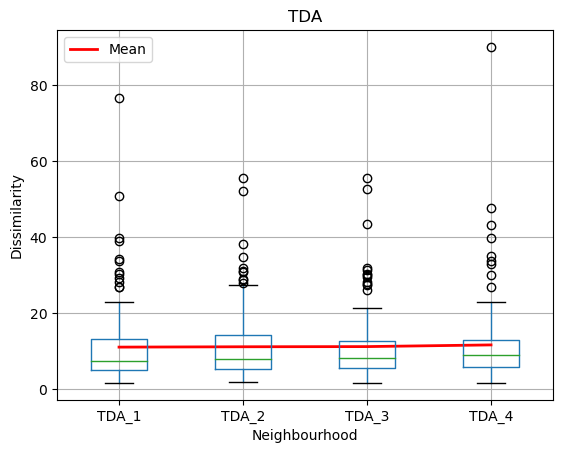

In [19]:
plt.plot(np.arange(len(median_TDA_log)) + 1, TDA_avaerage,linewidth=2, markersize=12,color='red',label ="Mean")
boxplot_TDA = df_read.boxplot(column=['TDA_1', 'TDA_2', 'TDA_3','TDA_4']) 
plt.xlabel('Neighbourhood')
plt.ylabel('Dissimilarity')
plt.title("TDA")
plt.legend()
plt.show()

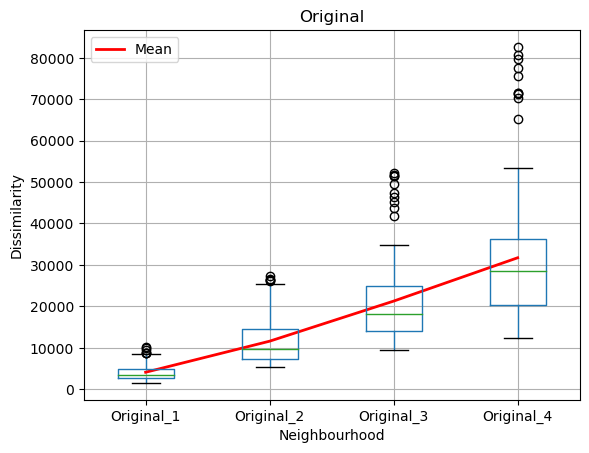

In [21]:
plt.plot(np.arange(len(original_average)) + 1, original_average,linewidth=2, markersize=12,color='red',label ="Mean")
boxplot_original = df_read.boxplot(column=['Original_1', 'Original_2', 'Original_3','Original_4']) 
plt.xlabel('Neighbourhood')
plt.ylabel('Dissimilarity')
plt.title("Original")
plt.legend()
plt.show()

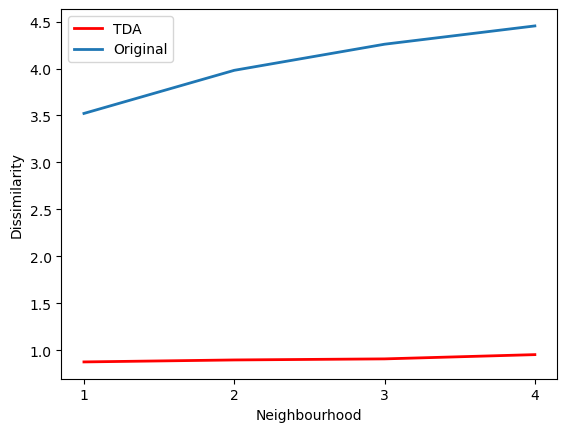

In [23]:
hop = ['1','2','3','4']
plt.plot(hop, median_TDA_log,linewidth=2, markersize=12,color='red',label ="TDA")
plt.plot(hop, median_original_log,linewidth=2, markersize=12, label="Original")
plt.xlabel('Neighbourhood')
plt.ylabel('Dissimilarity')
plt.legend()
plt.savefig("TDA-Original-ER.jpg")
plt.show()